In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
class ProductQuantization:
    def __init__(self, num_sub, num_clu):
        """
        Initialize the PQ class.

        Parameters:
        num_sub (type:int): Number of subvectors.
        num_clu (type:int): Number of clusters for each subvector space.
        """
        self.num_subvectors = num_sub
        self.num_clusters = num_clu
        self.codebooks = []


    def cut(self, data):
        """
        Split vectors into multiple subvectors.

        Parameters:
        data : Input vector data.

        Returns:
         Subvector arrays after splitting.
        """
        all_data = np.array([np.array_split(vec, self.num_subvectors) for vec in data])
        return all_data


    def kmeans(self, data):
        """
        Perform KMeans clustering for each subvector space and construct the codebook.

        Parameters:
        data : Input vector data.
        """
        # Split the input data into subvectors
        all_data = self.cut(data)

        for i in range(self.num_subvectors):
            # Extract the i-th subvector from each vector and stack them into an array
            sub_vectors = np.vstack([vec[i] for vec in all_data])

            # Perform KMeans clustering on this subvector space
            kmeans = KMeans(n_clusters=self.num_clusters, random_state=42).fit(sub_vectors)
            self.codebooks.append(kmeans.cluster_centers_)


    def quantize(self, vector):
        """
        Quantize the original vector into indices of the codebook.

        Parameters:
        vector : The input vector.

        Returns:
        List: Quantized indices.
        """
        # Calculate the size of each subvector by dividing the vector length by the number of subvectors
        subvector_size = len(vector) // self.num_subvectors
        quantized_indices = []

        for i in range(self.num_subvectors):
            # Extract the i-th subvector from the original vector
            subvector = vector[i*subvector_size:(i+1)*subvector_size]
            codebook = self.codebooks[i]

            # Calculate the Euclidean distance between the subvector and each centroid in the codebook
            distances = np.linalg.norm(codebook - subvector, axis=1)

            # Find the index of the closest centroid and add it to the quantized indices
            quantized_indices.append(np.argmin(distances))

        return quantized_indices


    def reconstruct(self, quantized_indices):
        """
        Reconstruct the vector based on the quantized indices.

        Parameters:
        quantized_indices : The list of quantized indices.

        Returns:
        The reconstructed vector.
        """
        reconstructed_vector = []

        for i, idx in enumerate(quantized_indices):
            reconstructed_vector.append(self.codebooks[i][idx])

        return np.concatenate(reconstructed_vector)

    def compute_error(self, original_vector, reconstructed_vector):
        """
        Compute the absolute and relative error between original and reconstructed vector.

        Parameters:
        original_vector : The original vector.
        reconstructed_vector : The reconstructed vector.

        Returns:
        Tuple: Absolute error, relative error.
        """
        absolute_error = np.linalg.norm(original_vector - reconstructed_vector)
        relative_error = absolute_error / np.linalg.norm(original_vector)

        return absolute_error, relative_error


    def evaluate_dataset(self, data):
        """
        Evaluate the average error across the dataset.

        Parameters:
        data : Input dataset.

        Returns:
        Tuple: Mean absolute error, mean relative error.
        """
        absolute_errors = []
        relative_errors = []

        for vector in data:
            quantized_indices = self.quantize(vector)
            reconstructed_vector = self.reconstruct(quantized_indices)
            abs_err, rel_err = self.compute_error(vector, reconstructed_vector)
            absolute_errors.append(abs_err)
            relative_errors.append(rel_err)

        return np.mean(absolute_errors), np.mean(relative_errors)


    def print_codebooks(self):
        """
        Print the codebook for each subvector space by converting cluster centers into DataFrame format for easy viewing.

        Returns:
        List (type:Tuple): A list containing the codebook for each subvector space. Each element is a tuple with subvector label and corresponding DataFrame.
        """
        # List to store DataFrames of codebooks for each subvector space
        codebook_dfs = []

        for i, codebook in enumerate(self.codebooks):
            df = pd.DataFrame(codebook)
            codebook_dfs.append((f"Subvector {i + 1} Codebook:", df))

        return codebook_dfs


    def display_example(self, vector):
        """
        Display the quantized indices and reconstruction result of the original vector.

        Parameters:
        vector : The input original vector.

        Returns:
        DataFrame: A DataFrame containing the original vector, quantized indices, and reconstructed vector.
        """
        # Quantize the input vector to obtain quantized indices for each subvector
        quantized_indices = self.quantize(vector)

        # Reconstruct the vector based on the quantized indices
        reconstructed_vector = self.reconstruct(quantized_indices)

        df = pd.DataFrame({
            "Original Vector": vector,
            "Quantized Index": quantized_indices * (len(vector) // self.num_subvectors),
            "Reconstructed Vector": reconstructed_vector
        })

        return df

# Generate cluster centers and add noise to create data
def generate_clustered_data(num_samples, vector_dim, num_clusters, noise_std=0.1):
    """
    Generate a synthetic dataset with clustered data points around random cluster centers.

    Parameters:
    num_samples (type:int) : Number of data samples to generate.
    vector_dim (type:int) : Dimensionality of each vector.
    num_clusters (type:int) : Number of clusters to form.
    noise_std (type:float): Standard deviation of the Gaussian noise to add to each sample, default is 0.1.
    """
    centers = np.random.uniform(-5, 5, (num_clusters, vector_dim))
    data = []
    for i in range(num_samples):
        center = centers[np.random.randint(num_clusters)]
        noisy_vector = center + np.random.normal(0, noise_std, vector_dim)
        data.append(noisy_vector)
    return np.array(data), centers

# Create data with cluster centers + noise
num_samples = 1000
vector_dim = 768
num_clusters_per_subspace = 16
num_subvectors = 4

# Create data with centre and noise
data, true_centers = generate_clustered_data(num_samples, vector_dim, num_clusters_per_subspace)

# Initialise PQ and train with KMeans
pq = ProductQuantization(num_sub=num_subvectors, num_clu=num_clusters_per_subspace)
pq.kmeans(data)

# Display example vectors, quantised indexes and reconstruction results
example_df = pq.display_example(data[0])

# Show codebook for manual verification
codebook_results = pq.print_codebooks()

# Calculate and display the average error
mean_absolute_error, mean_relative_error = pq.evaluate_dataset(data)

example_df

,Original Vector,Quantized Index,Reconstructed Vector
0,2.389365,1,2.479545
1,4.491701,12,4.454440
2,3.436996,7,3.371536
3,3.758700,12,3.628042
4,4.328924,1,4.410745
...,...,...,...
763,3.360278,12,3.237227
764,3.972487,1,3.824639
765,3.344400,12,3.205277
766,-3.379061,7,-3.348799


In [3]:
example_df

,Original Vector,Quantized Index,Reconstructed Vector
0,2.389365,1,2.479545
1,4.491701,12,4.454440
2,3.436996,7,3.371536
3,3.758700,12,3.628042
4,4.328924,1,4.410745
...,...,...,...
763,3.360278,12,3.237227
764,3.972487,1,3.824639
765,3.344400,12,3.205277
766,-3.379061,7,-3.348799


In [4]:
# codebooks
for label, df in codebook_results:
    display(df)

,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,191
0,0.379711,-2.363978,0.477903,-0.180999,-1.595003,2.093338,-0.440963,2.523233,1.701436,-2.954367,...,1.476951,1.404684,1.917085,2.381712,-0.171804,-0.435093,-1.997948,1.728992,-1.312814,-4.113230
1,2.479545,4.454440,3.371536,3.628042,4.410745,-1.743727,0.398635,0.957423,3.273473,1.095252,...,-1.791857,0.063168,-2.301422,-3.758259,2.741130,4.871202,-2.816377,-3.933516,4.152171,4.714076
2,1.732582,1.932814,-2.370911,-4.082906,2.985517,2.430034,-4.952304,0.014623,1.563600,-4.912896,...,-1.569811,-4.233472,0.124964,3.113997,0.969500,1.430616,2.078101,-3.647162,1.986500,1.334380
3,-4.460523,4.945690,-3.144174,-3.699700,0.951544,3.012737,-3.103684,2.009489,-3.349693,-1.012837,...,-1.117867,3.554936,3.147936,-1.764162,-2.209080,-4.433740,-4.432909,-3.728311,-2.781323,-2.699611
4,-1.379170,3.713106,-3.161646,-1.097956,1.412698,-1.022284,4.470775,-1.315721,2.889822,-4.225363,...,0.618660,2.806859,-4.024689,0.519128,3.953927,4.352874,-1.573693,2.683925,4.933662,-2.875461
5,2.005187,-2.661049,-2.437554,2.984909,-3.796889,3.741746,-1.390478,-1.271473,2.525236,-3.680422,...,2.216655,-4.664663,3.993008,0.590319,-4.249513,1.451948,-1.363098,-1.494447,-2.559515,-1.796905
6,0.819093,-0.461608,2.252626,0.321406,2.130123,-2.010428,-1.925273,-3.426732,2.012214,3.876241,...,4.510121,-1.302165,4.516156,4.393513,-4.843364,3.835747,4.691506,-0.624032,3.005113,1.494024
7,3.608655,3.850485,4.489493,-0.929816,0.383510,4.641533,3.115223,-4.418826,-3.322231,-0.095137,...,-0.192536,-1.171642,2.125164,0.487601,1.239038,4.294533,0.038905,-3.913968,-3.580398,-2.402671
8,2.952999,-4.874300,2.741201,3.979029,2.981433,0.438704,-0.794236,-2.514054,-2.131592,-1.480063,...,1.485558,-3.467773,1.853221,4.097953,0.394406,0.860016,3.087985,-0.592649,-4.361244,3.917900
9,-2.561672,-2.102432,4.947846,-3.465947,0.199312,-2.782601,3.743583,-1.777987,-3.411397,4.638547,...,-3.911394,-4.174421,-1.311505,-0.594703,4.654507,-0.374825,0.917974,-3.067483,0.451550,-3.601511


,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,191
0,-0.979226,3.746418,3.545681,0.858437,-3.786712,-1.525728,0.814679,-2.698092,-1.407476,-1.762858,...,4.431301,1.315750,-3.566080,-1.592851,-4.644745,0.926586,-4.912852,-4.349898,-1.851640,-4.375923
1,2.029759,3.248238,3.270879,1.033704,3.182272,-1.991004,3.421433,-2.043316,1.315481,-1.251933,...,4.625700,2.319620,0.686461,-4.580937,4.516179,-2.735275,4.778961,0.615742,-2.727346,2.534321
2,4.813403,-4.935013,-4.316526,-0.166347,-4.919263,0.485132,-4.425353,-2.936429,-1.464679,-1.848398,...,1.174789,-3.285074,0.807119,-3.598190,2.476835,-3.198939,-2.450684,-0.136445,-1.905971,-2.759898
3,0.830959,-4.830526,3.981202,3.044698,-4.118176,2.964648,1.781424,-0.263148,-1.272849,4.028993,...,-3.573177,3.836797,-4.510487,3.362701,-1.469074,4.473034,-2.692160,1.263622,-1.482196,-0.624157
4,-0.862559,4.568196,3.151984,0.253908,3.039433,3.568506,-1.041900,4.774617,-1.072959,-3.742381,...,-4.459612,-0.701482,-2.681739,-2.053257,3.245757,-1.486344,-3.463691,-4.285294,2.964811,-1.498241
5,3.125699,1.215693,-3.941044,4.489552,4.928407,1.858124,-0.326264,-4.608515,-1.097756,-4.935053,...,-3.547166,3.363959,4.330110,-1.638851,-2.921483,1.076207,2.036124,2.197522,1.494751,0.419625
6,-1.042568,0.493075,2.651778,4.408173,-3.725077,0.102444,-0.544403,-3.450656,4.222744,-1.755085,...,0.571043,-3.010697,-0.431467,-2.223143,-0.487925,-1.316229,-4.290619,2.384495,-1.301044,-0.350509
7,3.041593,-0.661807,3.146366,-2.503905,-2.227805,-4.034901,-0.399921,-2.949578,-1.938779,-0.859613,...,4.238854,0.169648,-3.853528,-4.488442,-4.628176,0.587847,0.955980,-0.022435,-3.542142,-2.638161
8,-4.372363,1.712233,2.082522,-4.571821,-0.870947,2.523419,1.555606,4.423224,-3.610233,-0.896309,...,2.669827,2.505944,-4.883016,0.199839,1.970566,-1.843820,-1.946311,1.600347,-1.747471,-0.687905
9,4.483110,4.241360,1.037929,-2.100331,0.663953,2.774512,2.168485,-0.800250,-4.236371,0.969788,...,-1.569569,1.849817,-2.197118,-4.446075,-1.997370,2.863744,-4.496552,-0.211515,2.598333,-4.242337


,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,191
0,3.738738,-4.593895,4.031797,-0.672104,-3.624302,-1.586452,-4.361021,-4.210709,0.479544,-0.192395,...,-0.592195,-3.446456,-2.687820,1.197305,-1.140635,-3.315698,-1.227839,-4.518464,1.622646,4.362714
1,-2.914535,-4.657918,3.186092,-1.453936,-1.352091,-0.026163,-1.000825,2.040057,-4.834682,3.293017,...,1.080580,-0.016136,0.590986,3.166494,-3.237487,-4.471347,-2.618482,1.738702,-2.408908,4.620681
2,4.150845,1.668416,3.878010,-1.238582,-1.459480,4.166220,-0.542687,-1.305864,1.698510,-2.596832,...,0.508922,3.552464,3.495972,0.740939,3.837720,2.977102,-2.221707,2.677931,-1.871221,-3.875249
3,1.387007,3.657191,0.606089,1.553706,-3.540737,4.146226,-2.568412,-0.210580,4.452645,1.882622,...,3.649119,-0.178329,-0.746994,-0.020107,-3.625072,-3.628067,-0.687870,3.275869,-3.734818,-3.884476
4,-3.584659,0.991051,0.258094,0.851646,1.634781,-3.759273,0.504035,1.638501,4.960667,0.955709,...,-1.789089,3.039839,-2.191462,1.088403,-3.835106,1.972583,-1.105344,3.599846,-4.095429,4.461312
5,-1.354618,4.219116,3.812512,2.079400,3.194717,-1.674346,-0.579446,-2.051219,1.566884,3.141321,...,-0.551749,-1.888199,-2.624432,2.665083,-4.871285,0.175465,-0.629819,3.288369,-4.154948,-4.594901
6,-2.735366,-2.386631,-4.182564,2.047538,0.604072,2.358173,-4.361883,-0.410921,0.426176,2.572009,...,4.903509,0.436158,-0.689682,1.305572,0.385925,3.986828,1.979666,-3.245178,-0.656880,-3.660609
7,-2.221813,-1.829025,-3.107394,-2.542153,-3.348485,4.872764,2.508310,-2.328806,-1.416578,-2.777049,...,-4.184541,1.278462,2.851091,-0.768134,4.440051,-1.380164,2.046118,4.178500,-0.642985,3.771963
8,-0.471718,2.849208,2.810360,2.211021,0.962460,-4.864829,0.769549,2.282600,-1.811145,-4.389444,...,3.182251,-4.731670,3.856632,1.385611,-0.018727,-4.716392,-4.489605,2.128749,4.399517,-3.392019
9,-0.404655,-0.357234,-1.095284,-2.088567,-1.484693,-2.332370,1.034494,3.280229,-3.301678,0.834394,...,-1.335070,3.273811,-0.665683,0.393442,-3.740414,3.368512,3.561018,-0.476009,-5.002765,-3.537631


,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,191
0,2.303174,2.158239,-3.431235,4.235941,4.352596,-3.859059,-2.308795,-3.673959,3.615563,4.865299,...,3.593101,-3.749051,-2.688985,0.503086,2.931712,-1.397749,0.796637,-1.790681,0.839651,2.845415
1,0.461065,-4.800205,-2.040565,-2.870508,2.676653,-3.342756,3.073003,-0.006351,4.570910,4.113399,...,2.785048,4.713488,2.916837,-3.380335,1.105519,2.942378,-1.611535,-4.606690,-4.007671,1.459547
2,-4.510137,-0.042021,0.955549,-4.563839,-0.109066,1.514188,1.251736,0.825028,2.620901,4.060570,...,-3.528460,2.546831,4.087549,3.259409,0.504498,2.094915,4.667171,-5.004851,4.827778,3.035180
3,0.807943,4.521862,-1.895643,-1.908565,-4.662611,-0.260584,-3.420694,0.644096,-4.408269,-0.992966,...,4.884638,-3.584902,2.996421,4.256912,0.695217,4.278115,4.337400,-2.581480,-2.185874,-3.979175
4,0.820160,2.854161,-3.947240,4.494679,-0.411637,3.696533,0.850772,-1.690484,-1.920559,0.124184,...,-4.311756,0.426198,-3.796891,1.873958,3.802485,-3.933103,-0.214076,3.420480,-4.750685,2.067924
5,0.442876,4.918541,-4.514406,-0.201256,-1.283562,1.051418,4.918719,3.097661,3.070383,-1.501337,...,-4.098532,0.866113,4.551020,1.694442,1.170241,3.193602,-4.869561,0.501819,-2.989602,-1.584841
6,-4.681608,-0.630007,-2.492914,-1.005902,-4.175948,4.956434,-0.082210,-3.058618,1.770466,0.447259,...,-1.407213,4.126015,3.990892,-4.966138,-0.135288,1.852697,2.948677,-0.741709,-0.266957,-2.373710
7,4.426899,3.512940,4.353978,1.860763,-2.895321,-4.680108,2.462545,-1.419228,-0.160136,-1.827080,...,4.830473,-3.985300,-4.185231,0.154633,-0.737192,-2.036229,-1.561020,2.501912,-1.619575,-1.971555
8,1.152969,-3.710152,-2.309627,-0.202576,0.830177,-1.117385,1.142513,-3.699495,0.785659,0.291141,...,-1.189030,-4.511257,4.620185,3.261568,0.624970,-3.684149,4.881000,3.851327,4.443946,2.581765
9,3.691074,-2.026434,1.272928,3.968117,-0.382003,-2.602719,-4.392295,4.294717,-3.344289,-2.804066,...,-4.935488,3.389057,4.721888,4.918902,0.627389,0.530606,3.404395,3.094840,1.644606,-0.548024


In [5]:
mean_absolute_error,mean_relative_error

(2.745556263215884, 0.0343465114676824)

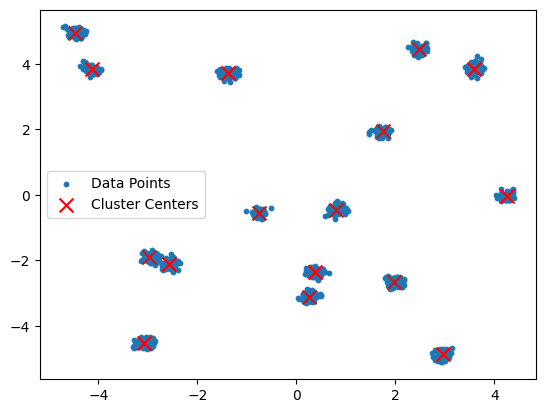

In [6]:
# Visualise data points and cluster centres and observe the cluster structure
plt.scatter(data[:, 0], data[:, 1], s=10, label="Data Points")
plt.scatter(true_centers[:, 0], true_centers[:, 1], color="red", marker="x", s=100, label="Cluster Centers")
plt.legend()
plt.show()

-The **Mean Absolute Error** of 2.751488 indicates that the compressed vectors produce some error in reconstruction.

-The **Mean Relative Error**of 3.44% is relatively small, indicating that most of the features of the original vectors are better preserved after quantisation and reconstruction.